In [1]:
import datetime
import warnings
from astropy.io import fits
import webbpsf
import numpy as np
import pprint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Generate OTE-01 Data

Email from Marshall:
- Create 18 independent segment PSFs centered on each segment, each with some suitably small size rather than gigantic: 
    - Apply random perturbations as you are doing. 
    - For each segment, cut out just that segment from the OPD map (using the one_segment_pupil helper function in WebbPSF).
    - This part’s somewhat tricky. For each segment we will want to record what the tip/tilt  is, then zero it out before creating the PSF (so that we get the PSF centered on where the segment is). We can use the tip/tilt values in the OPD to compute the equivalent vector to where that PSF would be. 
    - End result should be 18 separate PSF arrays, plus for each one a tip/tilt vector saying where that should appear relative to the center of the PSF array.
 - Iterate over the list of targets in MIRAGE
- For each target, iterate over the list of 18 PSFs and their offsets. 
- Compute the apparent location of that PSF as the sum of the coordinates that star would normally have in the field of view plus the offset to that PSF.
- If that PSF falls inside the detector field of view somewhere, put it there. Otherwise, skip that PSF. 

In [4]:
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

In [100]:
# Randomly generate a expected deployment tolerances.
# Deployment tolerances taken from JWST WFS&C Commissioning and Operations Plan (OTE-24):
# D36168 / 2299462 Rev C Page 10

deployment_errors = {
    'sm_piston': np.random.random(1) * 5000 - 2500,  # microns
    'sm_tilt': np.random.random(2) * 2600 - 1300,  # microradians
    'sm_decenter': np.random.random(2) * 5000 - 2500,  # microns
    'pm_piston': np.random.random(18) * 3000 - 1500,  # microns
    'pm_tilt': np.random.random((18, 2)) * 2200 - 1100,  # microradians
    'pm_decenter': np.random.random((18, 2)) * 2600 - 1300,  # microns
    'pm_roc' : np.random.random(18) * 302 - 151,  # microns
    'pm_clocking' : np.random.random(18) * 2400 - 1200,  # microradians
    'global_pm_piston' : np.random.random(1) * 1400 - 700,  # microns
    'global_pm_tilt' : np.random.random(2) * 380 - 190,  # microradians
    'global_pm_decenter' : np.random.random(2) * 400 - 200,  # microns
    'global_pm_clocking' : np.random.random(1) * 300 - 150,  # microradians
}
pprint.pprint(deployment_errors)

{'global_pm_clocking': array([146.47633046]),
 'global_pm_decenter': array([ -6.93933757, 141.23088418]),
 'global_pm_piston': array([-51.81411743]),
 'global_pm_tilt': array([-176.36546861,  146.3336725 ]),
 'pm_clocking': array([  705.84106403,  -308.88092499,   556.47155675, -1016.5801109 ,
        -247.46186347, -1044.66305631,   -97.43629348,  -257.42209336,
        -680.2840627 ,   280.66542244,   858.48365184,  -142.88299746,
        -231.88101685,  -482.3774315 ,  -161.02001338,  1149.49044934,
         261.20536278,  -239.62139148]),
 'pm_decenter': array([[ -259.66751587, -1239.52882448],
       [ -651.1685327 ,   -45.14485003],
       [   15.22160106,  1058.40101855],
       [-1259.57113909,   233.55861881],
       [  136.176534  ,  -909.86947532],
       [  650.462368  ,   356.07955297],
       [  -64.96848636,   904.06357239],
       [  446.23160749,   419.20577105],
       [ -379.32020643,   942.68265644],
       [ 1062.84883894,   457.67417315],
       [  870.87659822,  

In [101]:
# Generate the OPD with the deployment errors
def apply_deployment_errors(deployment_errors):
    ote.reset()
    
    print(deployment_errors['sm_piston'])
    # Add SM moves
    ote.move_sm_local(
        piston=deployment_errors['sm_piston'], xtilt=deployment_errors['sm_tilt'][0],
        ytilt=deployment_errors['sm_tilt'][1], xtrans=deployment_errors['sm_decenter'][0],
        ytrans=deployment_errors['sm_decenter'][1])

    # Add PMSA (segment) moves
    for i, seg in enumerate(ote.segnames[0:18]):
        ote.move_seg_local(
            seg,
            piston=deployment_errors['pm_piston'][i] + deployment_errors['global_pm_piston'],
            xtilt=deployment_errors['pm_tilt'][i][0] + deployment_errors['global_pm_tilt'][0],
            ytilt=deployment_errors['pm_tilt'][i][1] + deployment_errors['global_pm_tilt'][1],
            xtrans=deployment_errors['pm_decenter'][i][0] + deployment_errors['global_pm_decenter'][0],
            ytrans=deployment_errors['pm_decenter'][i][1] + deployment_errors['global_pm_decenter'][1],
            roc=deployment_errors['pm_roc'][i],
            clocking=deployment_errors['pm_clocking'][i] + deployment_errors['global_pm_clocking']
        )
    return ote

[-1891.70634128]


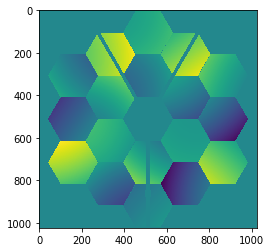

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	 -1013.6458  -720.0980   623.2171  1095.9964   300.3629   146.7545
A2	   -44.8752  -225.7747   402.5077 -1096.7433   429.2194    72.7931
A3	   -62.2325   973.5896  -181.2556   852.2051  1308.4118  -122.3805
A4	  -300.2649  -594.6905  -169.6401  -442.1572  1048.5465   146.3192
A5	    70.7926 -1001.4780   624.6237  -668.7154   731.9103   143.2520
A6	  -199.4644  -483.2114   686.5927  -718.0603  -530.5152  -128.2376
B1	   368.5961  -358.5500   -88.1304  -826.3545  1106.0027   -22.5125
C1	  -886.8361  -768.7307 -1110.3913  -297.5327    93.5736  -130.7014
B2	  -344.5579  1007.3776  1233.6069   871.7703 -1066.0406   -63.9955
C2	 -1012.9342   960.5948  -981.5225  -867.0146 -1411.9675   -97.1044
B3	  -595.8910  -779.9602   615.1490  -879.2069  -595.5926    39.3023
C3	   868.9251   415.3195  1518.6167   203.2113   13

In [7]:
# NEW: Record the tip/tilt
ote = apply_deployment_errors(deployment_errors)
plt.imshow(ote.opd)
plt.show()
ote.print_state()

[242.61051765]


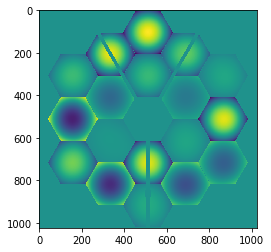

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    -6.3003    -4.0556    -6.6013    85.2317   109.8298   -13.4088
A2	   -96.4427    52.8791   -10.1540   -16.2405    -9.6086    -2.0300
A3	   -10.5881   -89.4402   -16.1094    70.2948  -119.9632     3.6905
A4	   -72.8626   -22.1799    43.6105   -87.0104   -37.4790    -4.2951
A5	    23.1673   -41.6758    79.0963   -10.0986    76.8639     5.9681
A6	   -91.9062    95.7812   -78.6448   -89.8187   -49.7310    -0.3154
B1	   -39.7701    25.2468   -82.5721     4.9040   104.5294    -3.1722
C1	  -123.7123     0.6889    49.5940   -11.0946    43.9292     8.4542
B2	   -14.9986   -53.0359   -89.7698   -53.3808   108.3914     6.5051
C2	    65.0387   107.1536    16.1983    42.7142   105.5910   -13.7599
B3	    77.1895    25.5696    29.0680   100.4960   141.7759    -2.0919
C3	  -106.3183    24.3879   -15.5675     0.3593   -5

In [102]:
reduced_deployment_errors = {}
for key, value in deployment_errors.items():
    reduced_deployment_errors[key] = value * 0.1
    
ote_reduced = apply_deployment_errors(reduced_deployment_errors)
plt.imshow(ote_reduced.opd)
plt.show()
ote_reduced.print_state()

In [103]:
ote = ote_reduced

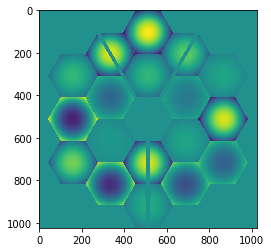

Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	     0.0000     0.0000     0.0000    85.2317   109.8298   -13.4088
A2	     0.0000     0.0000     0.0000   -16.2405    -9.6086    -2.0300
A3	     0.0000     0.0000     0.0000    70.2948  -119.9632     3.6905
A4	     0.0000     0.0000     0.0000   -87.0104   -37.4790    -4.2951
A5	     0.0000     0.0000     0.0000   -10.0986    76.8639     5.9681
A6	     0.0000     0.0000     0.0000   -89.8187   -49.7310    -0.3154
B1	     0.0000     0.0000     0.0000     4.9040   104.5294    -3.1722
C1	     0.0000     0.0000     0.0000   -11.0946    43.9292     8.4542
B2	     0.0000     0.0000     0.0000   -53.3808   108.3914     6.5051
C2	     0.0000     0.0000     0.0000    42.7142   105.5910   -13.7599
B3	     0.0000     0.0000     0.0000   100.4960   141.7759    -2.0919
C3	     0.0000     0.0000     0.0000     0.3593   -5

In [104]:
# Remove the piston/tip/tilt
ote.remove_piston_tip_tilt = True
# ote.update_opd()
# So it seems like update_opd() doesn't update the segment_state?

# That doesn't seem to work, so manually zero out the piston/tip/tilt
for segment in range(18):
    ote.segment_state[segment, :3] = 0
ote.update_opd()

plt.imshow(ote.opd)
plt.show()
ote.print_state()

/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py:629: UserWarning: For wavelength 1.749 microns, a FOV of 63.693 * 63.693 arcsec exceeds the maximum  spatial frequency well sampled by the input pupil. Your computed PSF will suffer from aliasing for angles beyond 27.968 arcsec radius.
  wl * 1e6, det_fov_arcsec[0], det_fov_arcsec[1], critical_angle_arcsec))
/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py:629: UserWarning: For wavelength 1.766 microns, a FOV of 63.693 * 63.693 arcsec exceeds the maximum  spatial frequency well sampled by the input pupil. Your computed PSF will suffer from aliasing for angles beyond 28.235 arcsec radius.
  wl * 1e6, det_fov_arcsec[0], det_fov_arcsec[1], critical_angle_arcsec))
/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py:629: UserWarning: For wavelength 1.782 microns, a FOV of 63.693 * 63.693 arcsec exceeds the maximum  spatial frequen

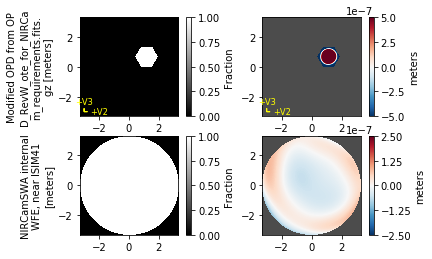

In [106]:
# Generate the PSF for a single segment pupil
i_segment = 2
pupil = webbpsf.webbpsf_core.one_segment_pupil(i_segment)
ote.amplitude = pupil[0].data

# Calculate the PSF
now = datetime.datetime.now()
psf_filename = "{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_segment{}_PSF.fits".format(
    now.year, now.month, now.day, now.hour, now.minute, now.second, i_segment
)

fov_pixels = 2048
psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=fov_pixels, add_distortion=False,
            outfile=psf_filename)
nc.display()

In [110]:
lam = 1.782e-6 # m
D = 6.5 # m
nircam_sw_pixel_scale = 0.031 # arcsec/pixel
print(512 * lam / D) # pixels

0.00014036676923076923


In [111]:
27.968 / nircam_sw_pixel_scale

902.1935483870968

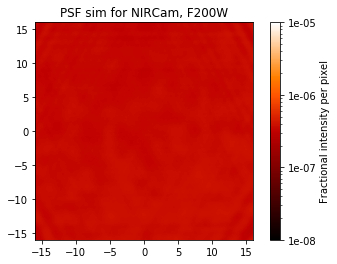

In [65]:
webbpsf.display_psf(psf, vmin=1e-8, vmax=1e-5)

Completed segment 1
Completed segment 2
Completed segment 3
Completed segment 4
Completed segment 5
Completed segment 6
Completed segment 7
Completed segment 8
Completed segment 9
Completed segment 10
Completed segment 11
Completed segment 12
Completed segment 13
Completed segment 14
Completed segment 15
Completed segment 16
Completed segment 17
Completed segment 18


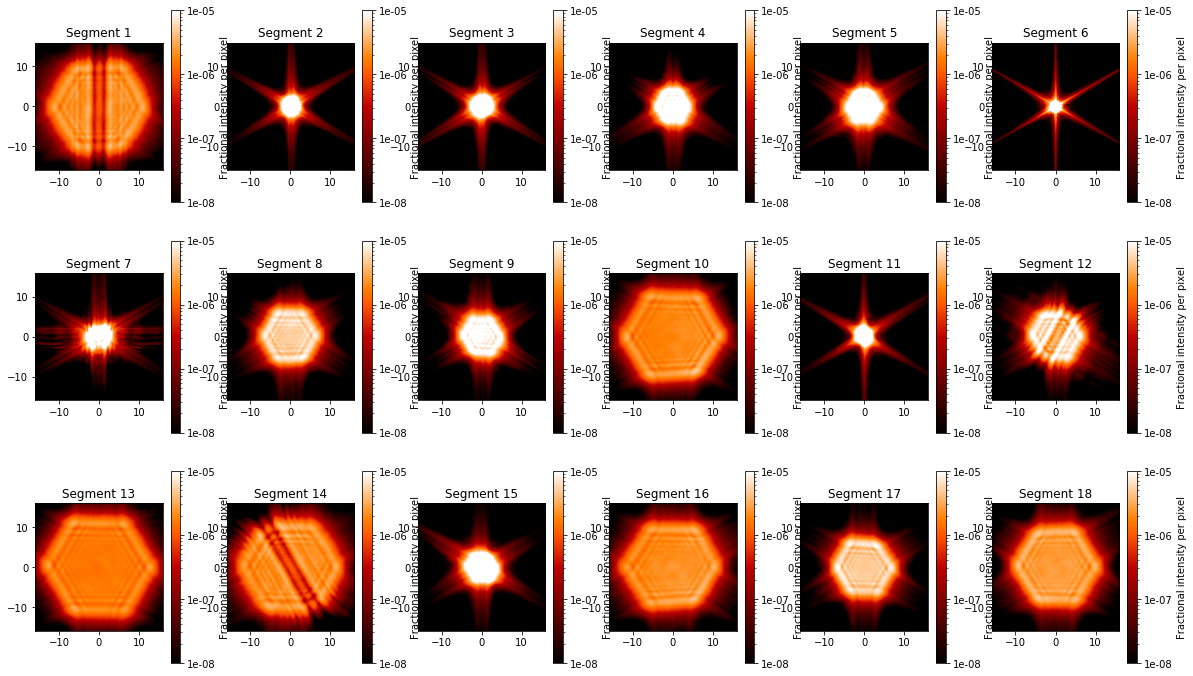

In [105]:
# Look at all 18 segments....
fig, ax_array = plt.subplots(3, 6, figsize=(20, 12))

for i in range (18):
    i_row = i // 6
    i_column = i % 6
    ax = ax_array[i_row, i_column]

    # Restrict the pupil to the current segment
    i_segment = i + 1
    pupil = webbpsf.webbpsf_core.one_segment_pupil(i_segment)
    ote.amplitude = pupil[0].data

    # Calculate and display the PSF
    fov_pixels = 1024
    psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=fov_pixels, add_distortion=False)
    webbpsf.display_psf(psf, vmin=1e-8, vmax=1e-5, ax=ax, title='Segment {}'.format(i+1))
    print('Completed segment {}'.format(i + 1))
    

now = datetime.datetime.now()
plot_filename = "{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_model_reduced_PSFs.jpg".format(
    now.year, now.month, now.day, now.hour, now.minute, now.second, i_segment
)
plt.savefig(plot_filename)
plt.show()

# Example: Generate PSF for just one segment

In [ ]:
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)
webbpsf.opds.setup_image_array(ote, size='large', reset=True, verbose=False)
psf = nc.calc_psf(nlambda=1, display=True, fov_pixels=2048)

/Users/lchambers/miniconda3/envs/mirage/lib/python3.6/site-packages/poppy/instrument.py:629: UserWarning: For wavelength 1.991 microns, a FOV of 63.693 * 63.693 arcsec exceeds the maximum  spatial frequency well sampled by the input pupil. Your computed PSF will suffer from aliasing for angles beyond 31.846 arcsec radius.
  wl * 1e6, det_fov_arcsec[0], det_fov_arcsec[1], critical_angle_arcsec))


In [ ]:
webbpsf.display_psf(psf, vmin=1e-12)

In [71]:
pupil = webbpsf.webbpsf_core.one_segment_pupil('A3')
# psf = nc.calc_psf(nlambda=1, display=True)
# plt.imshow(pupil[0].data)

In [72]:
ote.amplitude = pupil[0].data

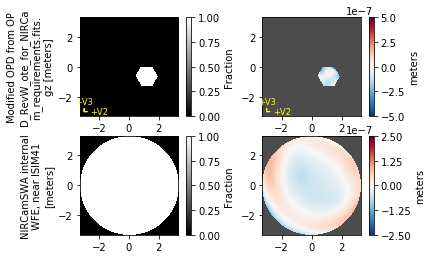

In [73]:
nc.display()

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x104fd40b8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x104fd4048>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c1b73edd8>]

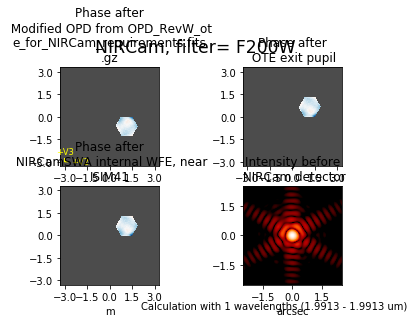

In [74]:
nc.calc_psf(nlambda=1, display=True)

# Generate segment PSF for telescope in image array

In [22]:
%%time
# Generate a PSF with a perturbed OTE according to the expected deployment tolerances.
# Deployment tolerances taken from JWST WFS&C Commissioning and Operations Plan (OTE-24):
# D36168 / 2299462 Rev C Page 10

nc = webbpsf.NIRCam()
# nc.filter = 'F212N'
nc, ote = webbpsf.enable_adjustable_ote(nc)

# *** QUESTION: Do I want to pull these random values from a normal distribution? ***

# Add SM moves
random_sm_piston = np.random.random(1) * 5000 - 2500 # microns
random_sm_tilt = np.random.random(2) * 2600 - 1300 # microradians
random_sm_decenter = np.random.random(2) * 5000 - 2500 # microns

ote.move_sm_local(piston=random_sm_piston, xtilt=random_sm_tilt[0], 
                  ytilt=random_sm_tilt[1], xtrans=random_sm_decenter[0],
                  ytrans=random_sm_decenter[1])  

# Add PMSA (segment) moves
random_pm_piston = np.random.random(18) * 3000 - 1500 # microns
random_pm_tilt = np.random.random((18, 2)) * 2200 - 1100 # microradians
random_pm_decenter = np.random.random((18, 2)) * 2600 - 1300 # microns
random_pm_roc = np.random.random(18) * 302 - 151 # microns
random_pm_clocking = np.random.random(18) * 2400 - 1200 # microradians

global_pm_piston = np.random.random(1) * 1400 - 700 # microns
global_pm_tilt = np.random.random(2) * 380 - 190 # microradians
global_pm_decenter = np.random.random(2) * 400 - 200 # microns
global_pm_clocking = np.random.random(1) * 300 - 150 # microradians

for i, seg in enumerate(ote.segnames[0:18]):
    ote.move_seg_local(seg, 
                       piston=random_pm_piston[i] + global_pm_piston,
                       xtilt=random_pm_tilt[i][0] + global_pm_tilt[0], 
                       ytilt=random_pm_tilt[i][1] + global_pm_tilt[1], 
                       xtrans=random_pm_decenter[i][0] + global_pm_decenter[0], 
                       ytrans=random_pm_decenter[i][1] + global_pm_decenter[1], 
                       roc=random_pm_roc[i], 
                       clocking=random_pm_clocking[i] + global_pm_clocking)

CPU times: user 50.8 s, sys: 6.54 s, total: 57.4 s
Wall time: 15.6 s


(<matplotlib.axes._subplots.AxesSubplot at 0x1c21072d68>,
 <matplotlib.colorbar.Colorbar at 0x10af227b8>)

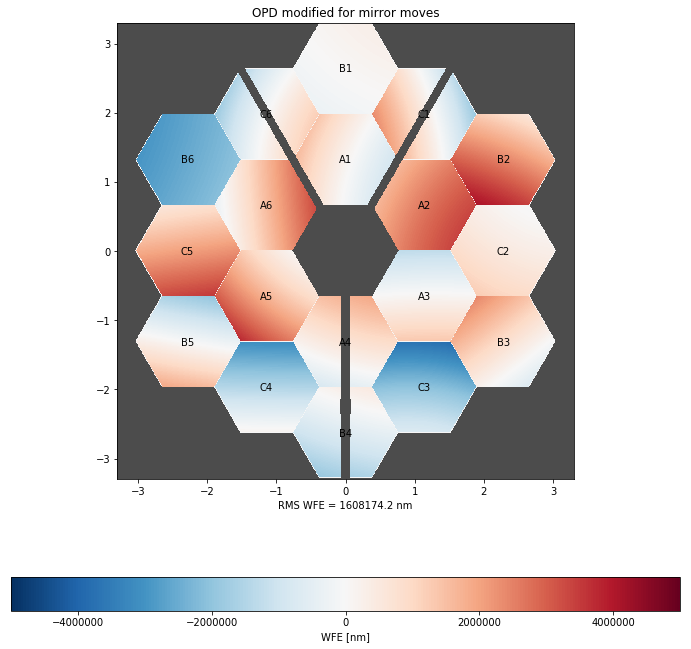

In [23]:
# Plot the OPD
plt.figure(figsize=(12,12))
ax1=plt.subplot(111)
ote.display_opd(ax=ax1, vmax=5e6, 
                colorbar_orientation='horizontal',
               title='OPD modified for mirror moves') #, cbpad=0.05)

In [24]:
# Save the OPD as a FITS file
now = datetime.datetime.now()
ote_filename = "{:4d}{:02d}{:02d}-{:02d}{:02d}{:02d}-OTE01_perturbedOTE.fits".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
print(ote_filename)
hdulist = fits.HDUList(hdus=ote.as_fits())
hdulist.writeto(ote_filename, output_verify='ignore')

20181029-171434-OTE01_perturbedOTE.fits


In [25]:
# Generate the PSF and save it as a file, too
now = datetime.datetime.now()
psf_filename = "{:2d}{:2d}{:2d}-{:2d}{:2d}{:2d}-OTE01_PSF.fits".format(now.year, now.month, now.day, now.hour, now.minute, now.second)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    %time ga_psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=500, add_distortion=False, outfile=psf_filename)#, display=True)

CPU times: user 28.3 s, sys: 1.88 s, total: 30.2 s
Wall time: 8.03 s


In [14]:
ga_psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     133   (500, 500)   float64   
  1  DET_SAMP      1 ImageHDU       134   (500, 500)   float64   


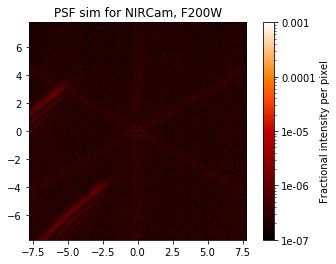

In [15]:
ax = webbpsf.display_psf(ga_psf, return_ax=True, vmin=1e-7, vmax=1e-3)
# ax = ax[0]
# ax.set_xlim(0, 20)
# ax.set_ylim(0, -20)

In [56]:
ga_psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     150   (500, 500)   float64   
  1  DET_SAMP      1 ImageHDU       152   (500, 500)   float64   
  2  OVERDIST      1 ImageHDU       196   (500, 500)   float64   
  3  DET_DIST      1 ImageHDU       197   (500, 500)   float64   


In [59]:
hdulist = fits.HDUList(ga_psf[1])
hdulist.writeto('OTE01_PSF_DET_SAMP.fits', output_verify='ignore')

In [27]:
pupil = webbpsf.webbpsf_core.one_segment_pupil(1)

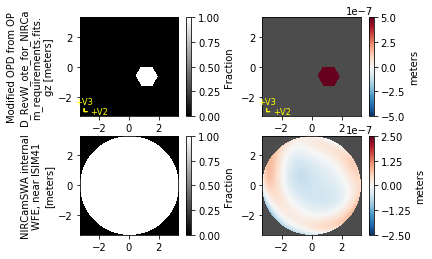

In [31]:
# Restrict the pupil to just be one segment
pupil = webbpsf.webbpsf_core.one_segment_pupil('A3')
ote.amplitude = pupil[0].data
nc.display()

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    %time ga_a3_psf = nc.calc_psf(nlambda=30, oversample=1, fov_pixels=1e4)#, display=True)

In [ ]:
ax = webbpsf.display_psf(ga_a3_psf, return_ax=True, vmin=1e-20, vmax=1e-4)
# ax = ax[0]
# ax.set_xlim(0, 20)
# ax.set_ylim(0, -20)

In [29]:
np.arange(1, 19)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])